In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from skimage import io
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

# Crowd counting

## Labeled images


In [3]:
annotations = pd.read_csv('images/annotations.csv', header=None, names=['class', 'x', 'y', 'image', 'w', 'h'])
images_paths = list(Path('images').glob('*.jpg'))

width, height = annotations[['w', 'h']].mean().astype(int)

# Load images and annotations
images_info = [
    {
        "image": io.imread(path).astype(np.uint8),
        "annotation": annotations[annotations['image'] == path.name][['x', 'y']],
    } 
    for path in images_paths]

# Add gray images
for info in images_info:
    info['gray_image'] = cv2.cvtColor(info['image'], cv2.COLOR_BGR2GRAY)


# Get reference image
reference_image_info = images_info[0]

# Get the rest of the images
images_info = images_info[1:]

In [4]:
images_info[0]["annotation"]

x    y
0   361  588
1  1366  607
2  1350  617
3  1319  456
4  1309  458
5  1469  464
6  1546  466
7  1561  452
8  1613  443

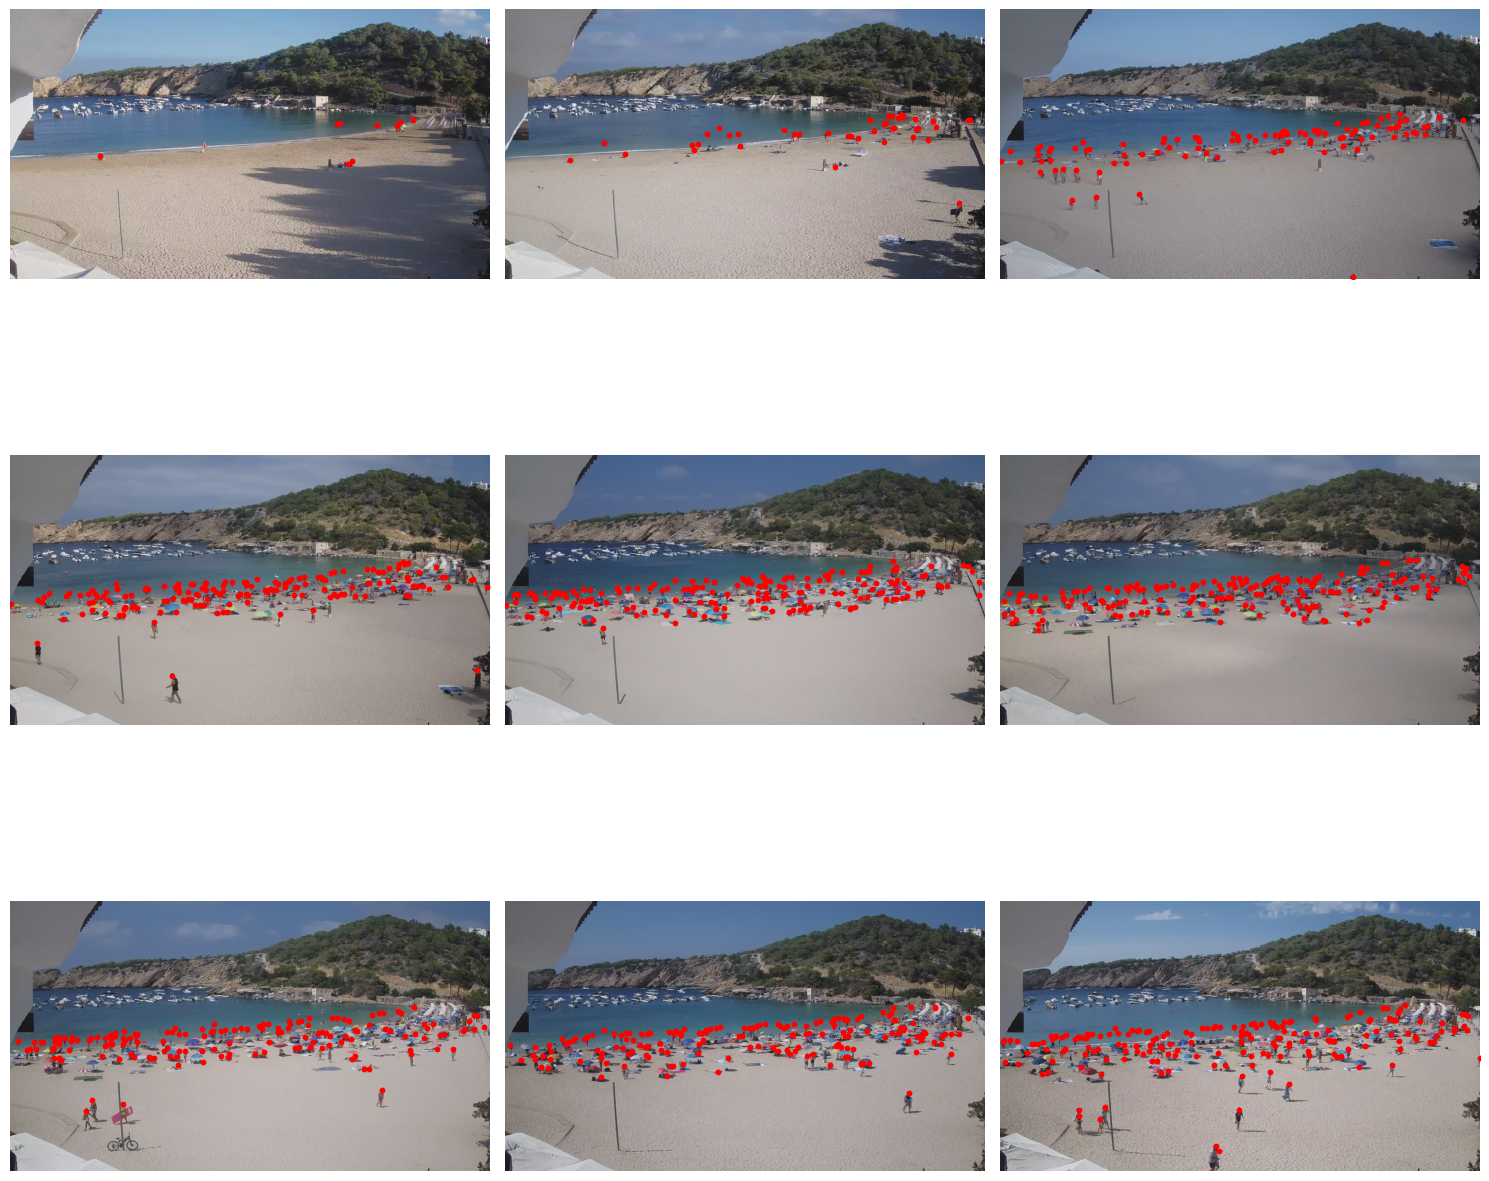

In [5]:
import matplotlib.pyplot as plt

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

axes = axes.flatten()

for i, info in enumerate(images_info):
    image = info['image']
    annotation = info['annotation']
    axes[i].imshow(image, cmap='gray')
    axes[i].scatter(annotation['x'], annotation['y'], color='red', marker='o', s=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


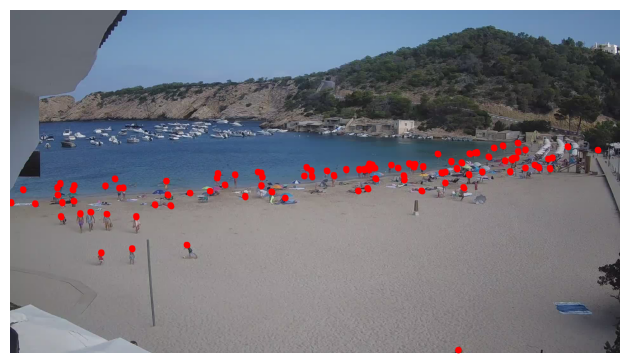

In [6]:
info = images_info[2]
image = info['image']
annotation = info['annotation']

# draw circles with cv2
for x, y in annotation.values:
    cv2.circle(image, (x, y), 10, (255, 0, 0), -1)

image_save = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# save image
cv2.imwrite('annotated.jpg', image_save)

plt.imshow(image, cmap='gray')
plt.scatter(annotation['x'], annotation['y'], color='red', marker='o', s=10)
plt.axis('off')

plt.tight_layout()
plt.show()

---

## Algorithm execution

First we need to read the images.

In [7]:
images = [io.imread(path) for path in Path('images').glob('*.jpg')]
images = images[1:]

In [8]:
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

reference_image = gray_images[0]
gray_images = gray_images[1:]


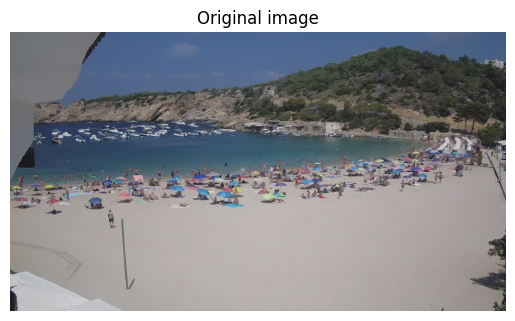

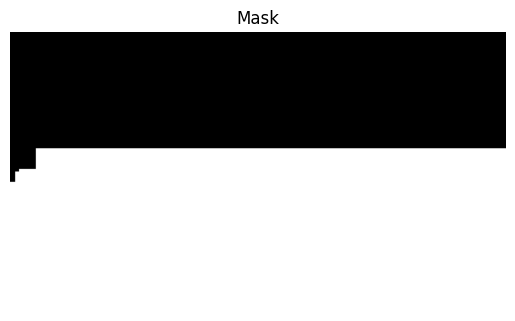

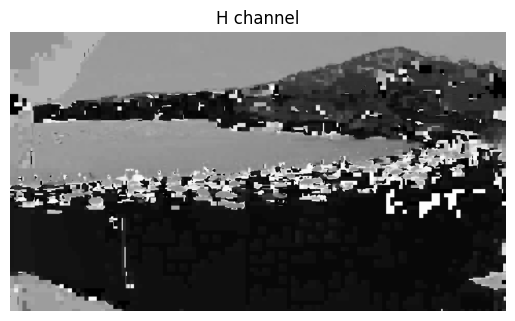

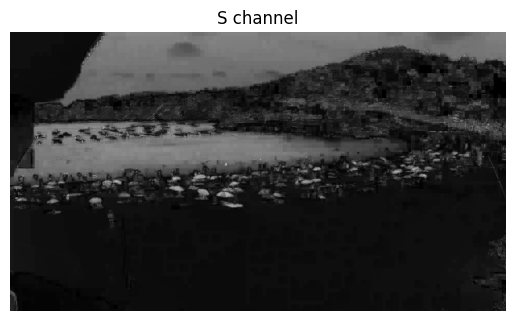

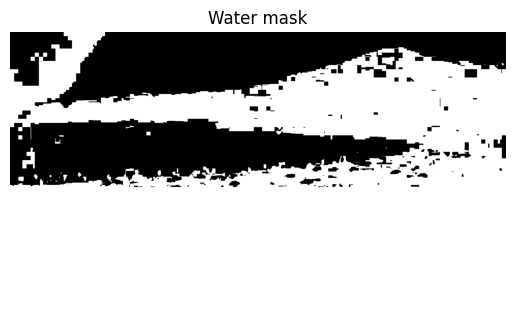

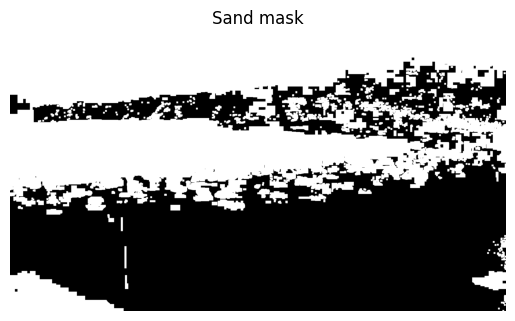

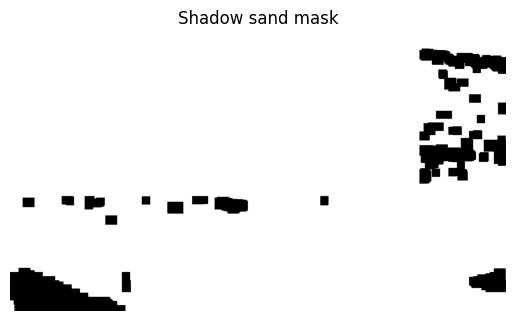

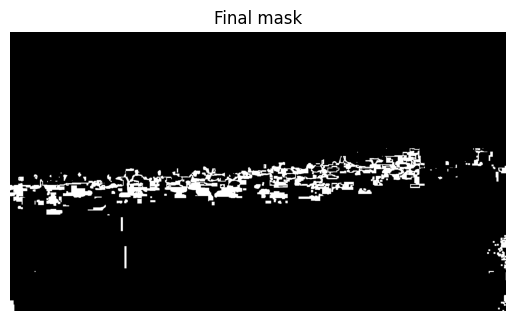

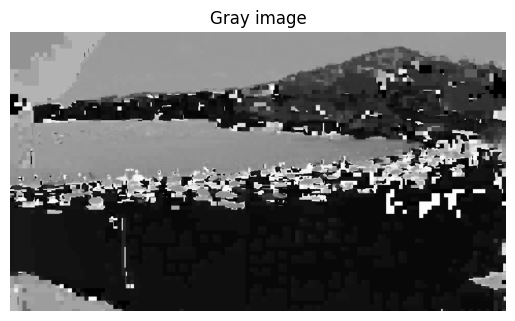

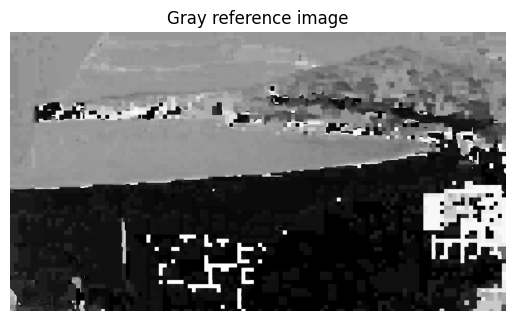

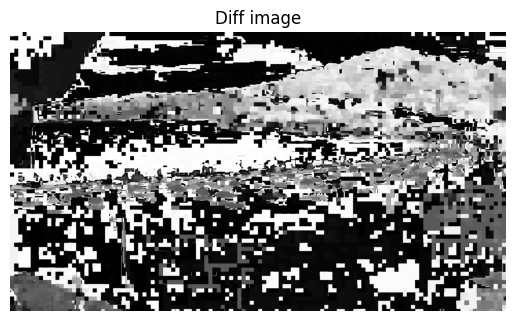

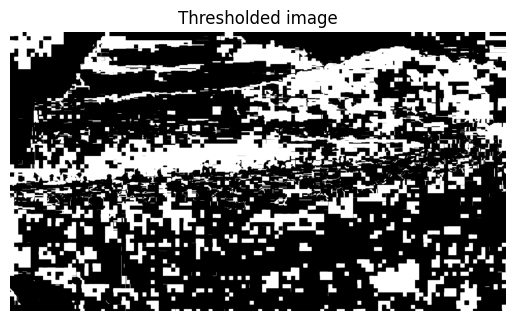

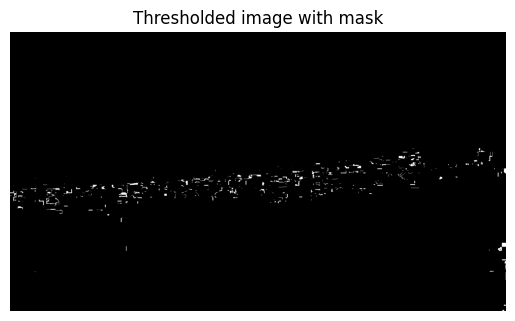

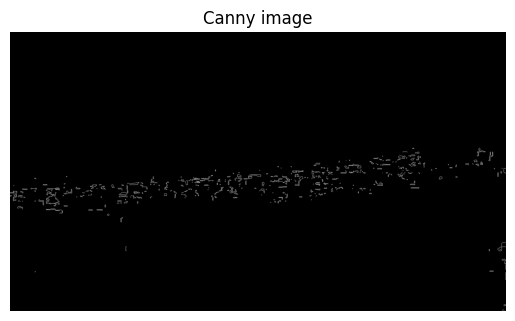

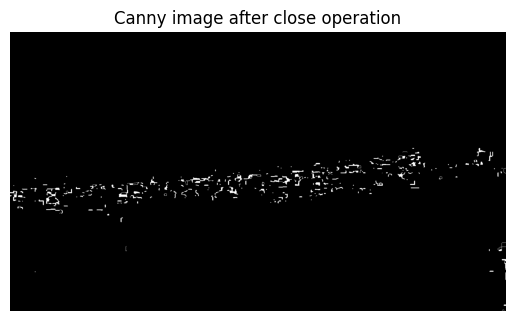

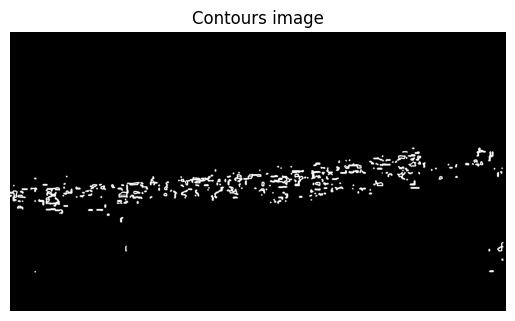

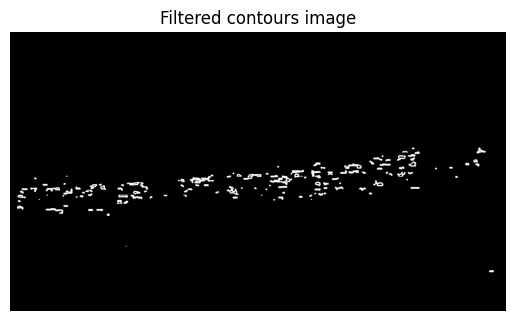

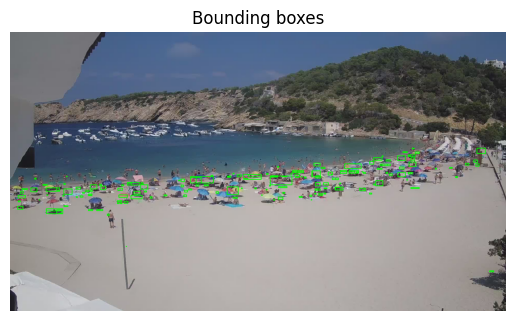

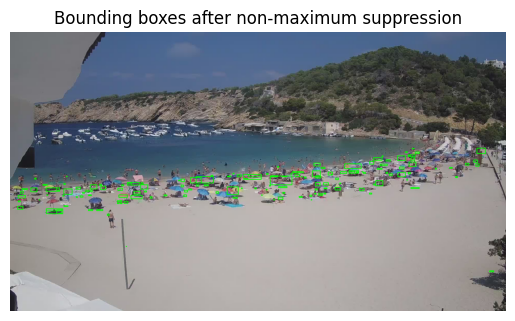

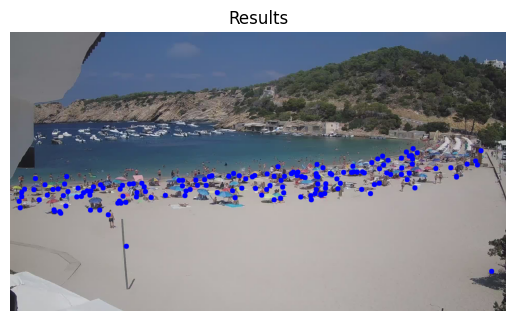

In [9]:
from lib.evaluate import evaluate_method
from methods.combined import locate_people

# Parameters of the model
threshold = 200
stride=90
patch_size=(200, 200)
aspect_ratio_threshold=1.3

results = [locate_people(image, threshold, stride, patch_size, aspect_ratio_threshold, debug=idx==4) for idx, image in enumerate(images)]
labels = [info["annotation"].copy()  for info in images_info]


res = evaluate_method(all_results=results, all_labels=labels, width=width, height=height, max_distance=150)

## Evaluation

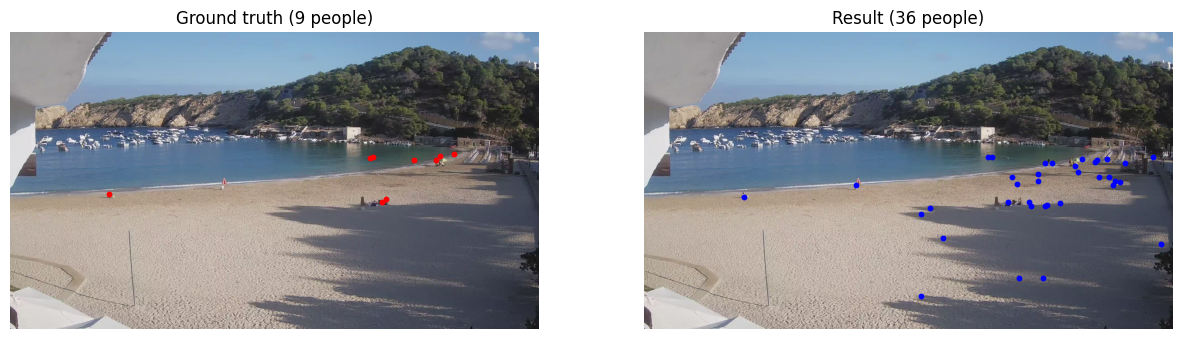

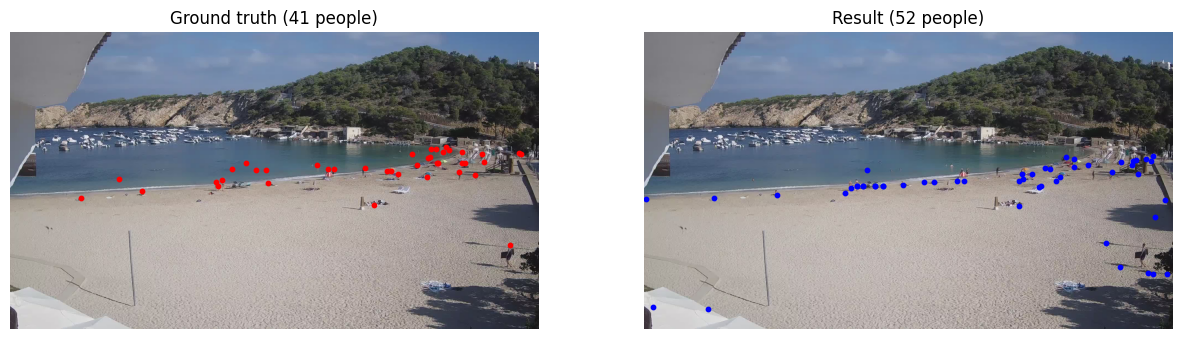

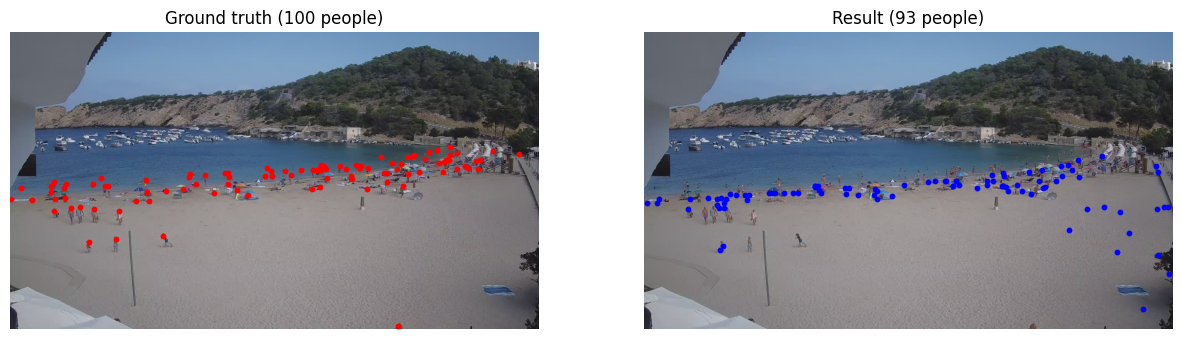

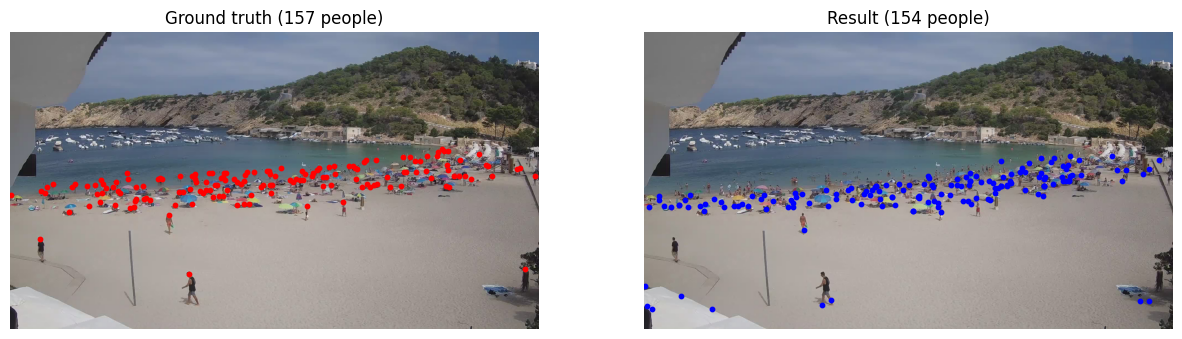

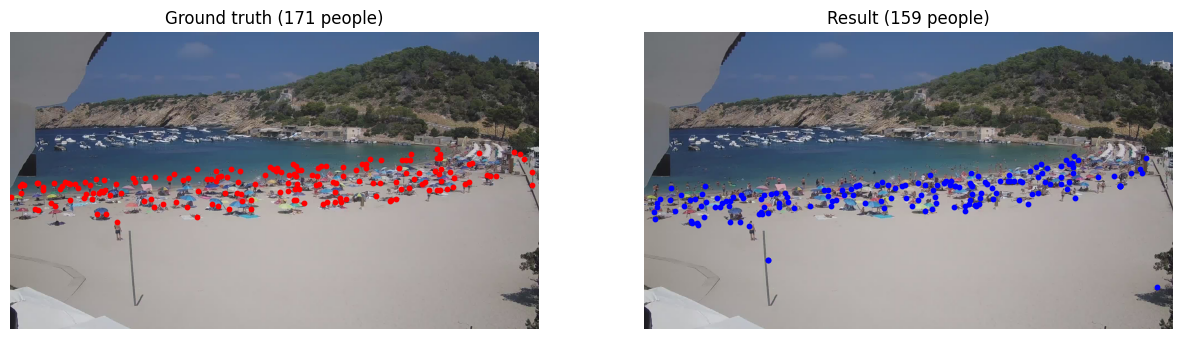

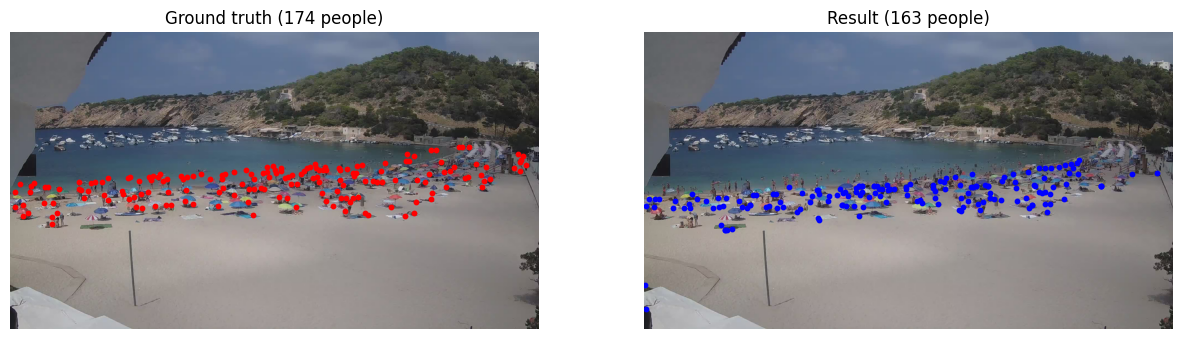

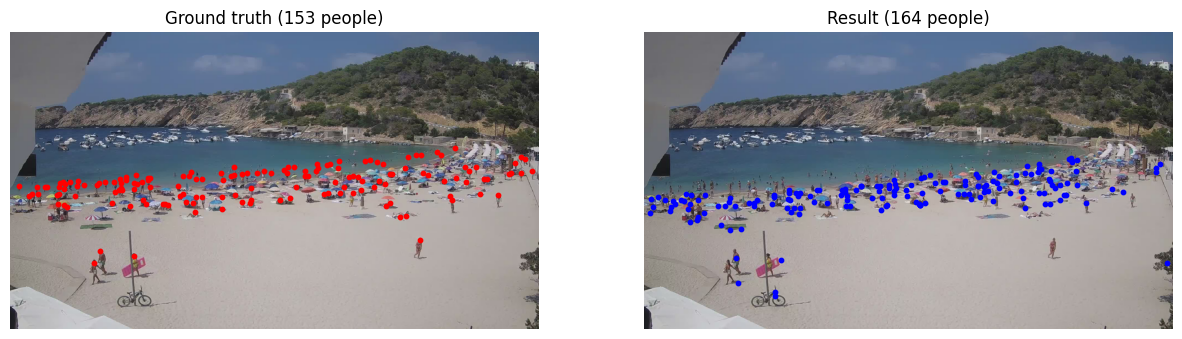

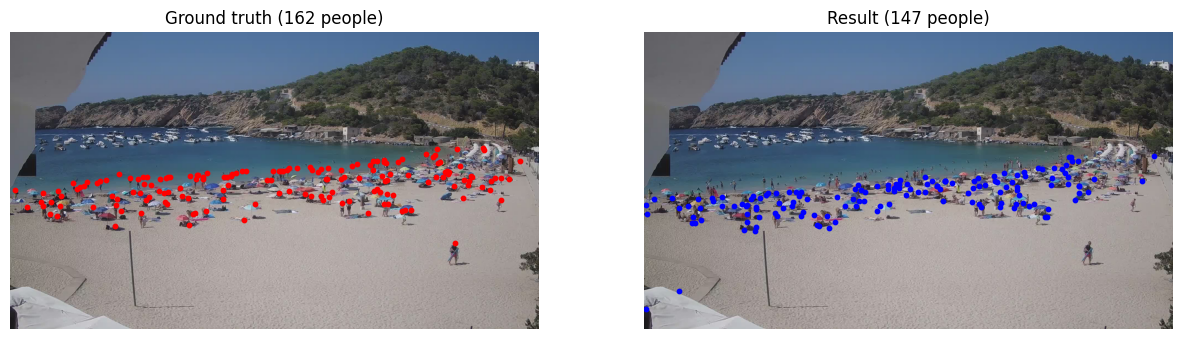

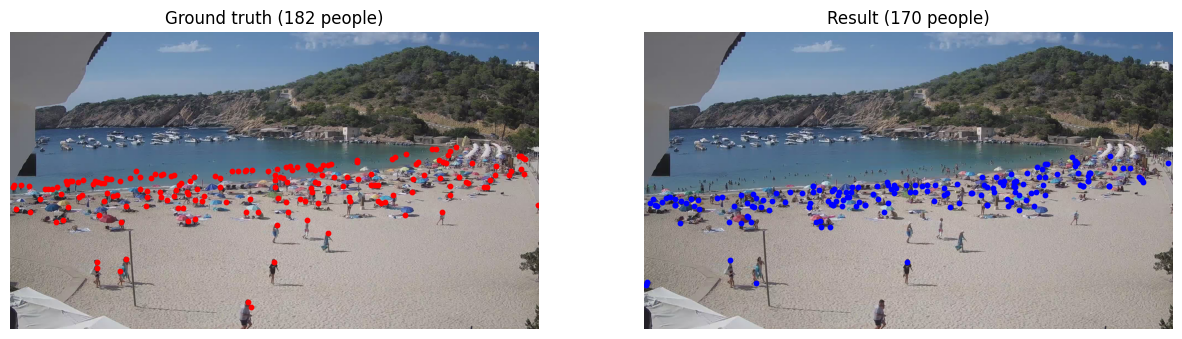

In [17]:
from lib.plot import plot_results_different_figures

plot_results_different_figures(images, results, labels, save_images=True)

### Image level evaluation

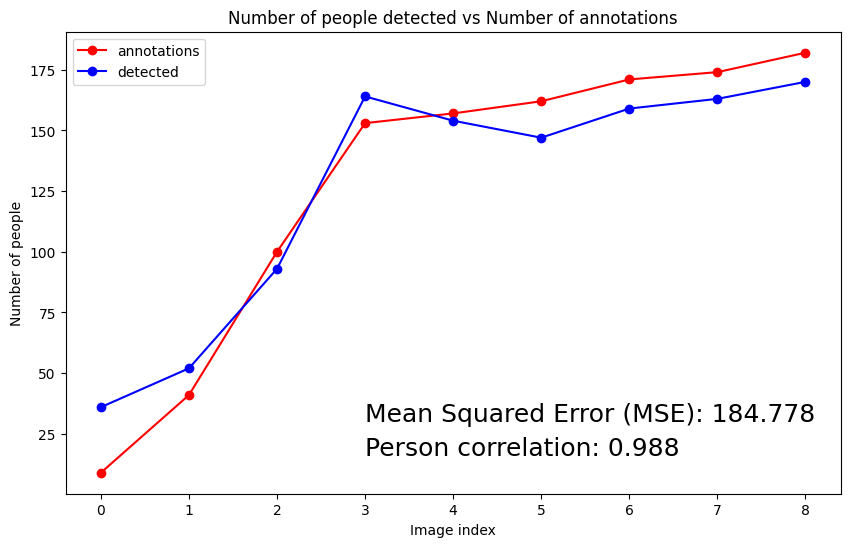

In [11]:
# Take the number of people detected and the number of annotations
n_detected = np.array([len(result) for result in results])
n_annotations = np.array([len(label_set) for label_set in labels])

# Take the indices that sort the number of annotations
sorted_indices = np.argsort(n_annotations)

# Sort the number of annotations and the number of detected people according to the indices
n_annotations = n_annotations[sorted_indices]
n_detected = n_detected[sorted_indices]

# Get the MSE and calculate the person correlation
mse_value = res['image_level']['value']
person_correlation = np.corrcoef(n_annotations, n_detected)[0, 1]


# Plot the number of annotations and the number of detected people to check if there is a correlation
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(n_annotations, 'ro-')
ax.plot(n_detected, 'bo-')
ax.legend(['annotations', 'detected'])
ax.set_xlabel('Image index')
ax.set_ylabel('Number of people')
ax.set_title('Number of people detected vs Number of annotations')
ax.text(3, 30, f'Mean Squared Error (MSE): {mse_value:.3f}', fontsize=18)
ax.text(3, 16, f'Person correlation: {person_correlation:.3f}', fontsize=18)
plt.show()

### Person level evaluation

In [12]:
from IPython.display import display, HTML

# Take the metrics of the person level
person_level = res['person_level']['metrics']
keys = ['accuracy', 'precision', 'recall', 'f1']

# Extract the mean and std of each metric
mean_values = [person_level[key] for key in keys]
std_values = [person_level[f'{key}_std'] for key in keys]

# Create a dataframe with the mean and std of each metric
values_df = pd.DataFrame({'mean': mean_values, 'std': std_values}, index=keys)


display(HTML(values_df.to_html()))
print(values_df.to_latex(bold_rows=True, float_format="%.3f", caption='Person level metrics.', label='tab:person_level_metrics'))

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.